In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize Spark session
spark = SparkSession.builder.appName("CarSalesAnalysis").getOrCreate()

# Load dataset
car_sales_df = spark.read.csv("file.csv", header=True, inferSchema=True)

# Show schema and preview data
car_sales_df.printSchema()
car_sales_df.show(5)


root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- DriveTrain: string (nullable = true)
 |-- MSRP: string (nullable = true)
 |-- Invoice: string (nullable = true)
 |-- EngineSize: double (nullable = true)
 |-- Cylinders: integer (nullable = true)
 |-- Horsepower: integer (nullable = true)
 |-- MPG_City: integer (nullable = true)
 |-- MPG_Highway: integer (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- Wheelbase: integer (nullable = true)
 |-- Length: integer (nullable = true)

+-----+--------------+-----+------+----------+--------+--------+----------+---------+----------+--------+-----------+------+---------+------+
| Make|         Model| Type|Origin|DriveTrain|    MSRP| Invoice|EngineSize|Cylinders|Horsepower|MPG_City|MPG_Highway|Weight|Wheelbase|Length|
+-----+--------------+-----+------+----------+--------+--------+----------+---------+----------+--------+---------

In [ ]:
from pyspark.sql.functions import regexp_replace, col, mean

# Remove currency symbols and convert MSRP and Invoice to numeric
car_sales_df = car_sales_df.withColumn("MSRP", regexp_replace(col("MSRP"), "[$,]", "").cast("double"))
car_sales_df = car_sales_df.withColumn("Invoice", regexp_replace(col("Invoice"), "[$,]", "").cast("double"))

# Fill missing values for Cylinders
mean_cylinders = car_sales_df.select(mean("Cylinders")).first()[0]
car_sales_df = car_sales_df.fillna({"Cylinders": mean_cylinders})

# Remove rows with NULL or missing values in selected columns (e.g., "MSRP", "Invoice", "Type")
car_sales_df = car_sales_df.dropna(subset=["MSRP", "Invoice", "Type", "Cylinders"])

# Verify the cleaning process
car_sales_df.show(5)


+-----+--------------+-----+------+----------+-------+-------+----------+---------+----------+--------+-----------+------+---------+------+
| Make|         Model| Type|Origin|DriveTrain|   MSRP|Invoice|EngineSize|Cylinders|Horsepower|MPG_City|MPG_Highway|Weight|Wheelbase|Length|
+-----+--------------+-----+------+----------+-------+-------+----------+---------+----------+--------+-----------+------+---------+------+
|Acura|           MDX|  SUV|  Asia|       All|36945.0|33337.0|       3.5|        6|       265|      17|         23|  4451|      106|   189|
|Acura|RSX Type S 2dr|Sedan|  Asia|     Front|23820.0|21761.0|       2.0|        4|       200|      24|         31|  2778|      101|   172|
|Acura|       TSX 4dr|Sedan|  Asia|     Front|26990.0|24647.0|       2.4|        4|       200|      22|         29|  3230|      105|   183|
|Acura|        TL 4dr|Sedan|  Asia|     Front|33195.0|30299.0|       3.2|        6|       270|      20|         28|  3575|      108|   186|
|Acura|    3.5 RL 4d

In [ ]:
from pyspark.sql.functions import format_number

# Calculate average price by car type and format to 2 decimal places
avg_price_by_type = car_sales_df.groupBy("Type").agg(mean("MSRP").alias("Avg_Price"))
avg_price_by_type = avg_price_by_type.withColumn("Avg_Price", format_number("Avg_Price", 2)).orderBy("Avg_Price", ascending=False)

# Show the results
print("Average Price by Car Type:")
avg_price_by_type.show()


Average Price by Car Type:
+------+---------+
|  Type|Avg_Price|
+------+---------+
|Sports|53,387.06|
|   SUV|34,790.25|
| Sedan|29,773.62|
| Wagon|28,840.53|
| Truck|24,941.38|
|Hybrid|19,920.00|
+------+---------+



In [ ]:
from pyspark.sql.functions import avg, round

# Average MPG by Origin with values rounded to 2 decimal places
mpg_by_origin = car_sales_df.groupBy("Origin").agg(
    round(avg("MPG_City"), 2).alias("Avg_MPG_City"),
    round(avg("MPG_Highway"), 2).alias("Avg_MPG_Highway")
)

# Show the results
mpg_by_origin.show()


+------+------------+---------------+
|Origin|Avg_MPG_City|Avg_MPG_Highway|
+------+------------+---------------+
|Europe|       18.73|          26.01|
|   USA|       19.07|          26.01|
|  Asia|       22.01|          28.27|
+------+------------+---------------+



In [ ]:
from pyspark.sql.functions import mean, round

# Calculate average price by maker and round to 2 decimals
top_makers = car_sales_df.groupBy("Make").agg(
    round(mean("MSRP"), 2).alias("Avg_Price")
).orderBy("Avg_Price", ascending=False)

# Show the top 5 results
top_makers.show(5)


+-------------+---------+
|         Make|Avg_Price|
+-------------+---------+
|      Porsche|  83565.0|
|       Jaguar| 61580.42|
|Mercedes-Benz| 60656.81|
|     Cadillac| 50474.38|
|       Hummer|  49995.0|
+-------------+---------+
only showing top 5 rows



<ipython-input-6-fbbaa8b77eba>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pandas_avg_price_by_origin, x="Origin", y="Avg_Price", palette="coolwarm")


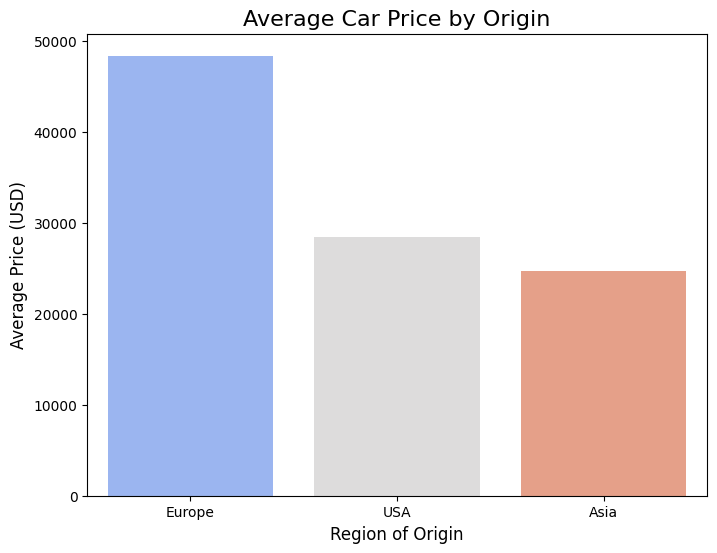

In [ ]:
# Average Price by Origin
avg_price_by_origin = car_sales_df.groupBy("Origin").agg(mean("MSRP").alias("Avg_Price")).orderBy("Avg_Price", ascending=False)

# Convert to Pandas for visualization
pandas_avg_price_by_origin = avg_price_by_origin.toPandas()

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=pandas_avg_price_by_origin, x="Origin", y="Avg_Price", palette="coolwarm")
plt.title("Average Car Price by Origin", fontsize=16)
plt.xlabel("Region of Origin", fontsize=12)
plt.ylabel("Average Price (USD)", fontsize=12)
plt.show()


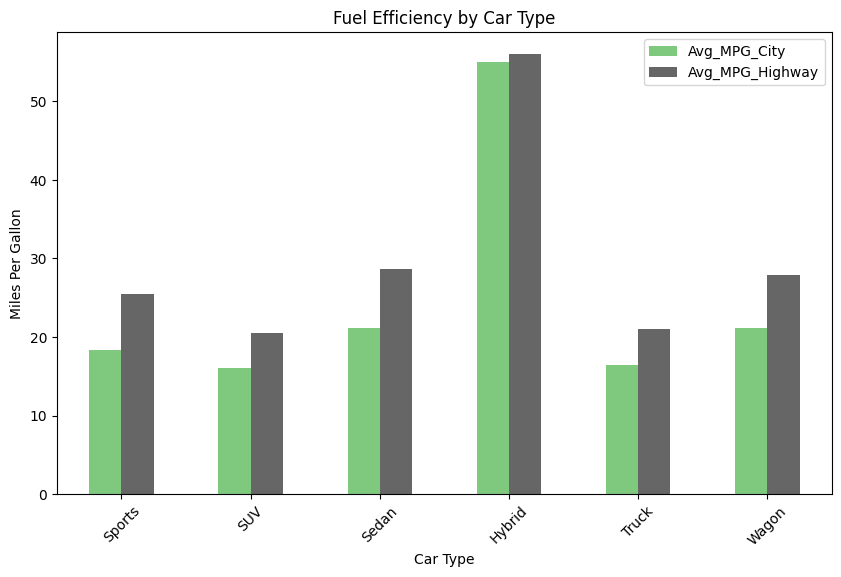

In [ ]:
# Group by Type for MPG averages
mpg_by_type = car_sales_df.groupBy("Type").agg(
    mean("MPG_City").alias("Avg_MPG_City"),
    mean("MPG_Highway").alias("Avg_MPG_Highway")
)

# Convert to Pandas for visualization
pandas_mpg_by_type = mpg_by_type.toPandas()

# Plot
pandas_mpg_by_type.plot(
    kind="bar",
    x="Type",
    y=["Avg_MPG_City", "Avg_MPG_Highway"],
    title="Fuel Efficiency by Car Type",
    ylabel="Miles Per Gallon",
    xlabel="Car Type",
    rot=45,
    figsize=(10, 6),
    colormap="Accent",
)
plt.show()


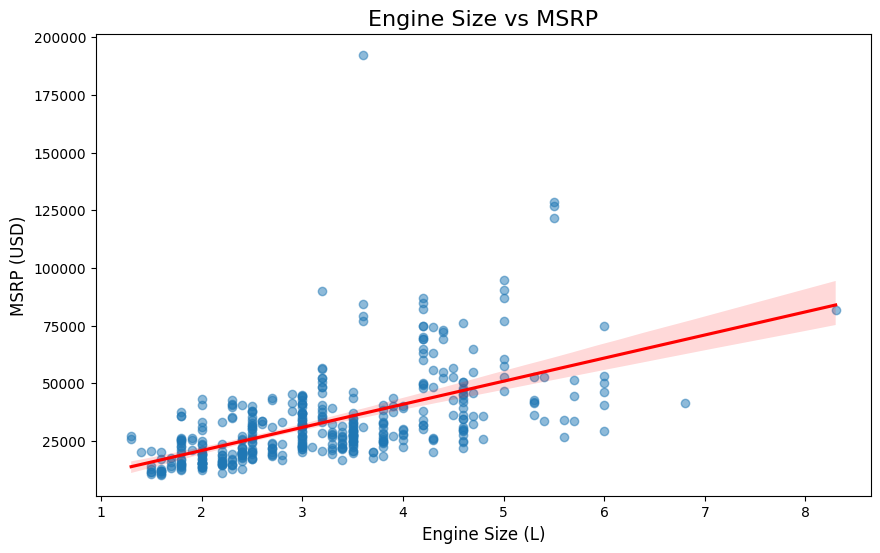

In [ ]:
# Convert Spark DataFrame to Pandas for regression plot
pandas_data = car_sales_df.select("EngineSize", "MSRP").toPandas()

# Plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=pandas_data, x="EngineSize", y="MSRP", scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.title("Engine Size vs MSRP", fontsize=16)
plt.xlabel("Engine Size (L)", fontsize=12)
plt.ylabel("MSRP (USD)", fontsize=12)
plt.show()


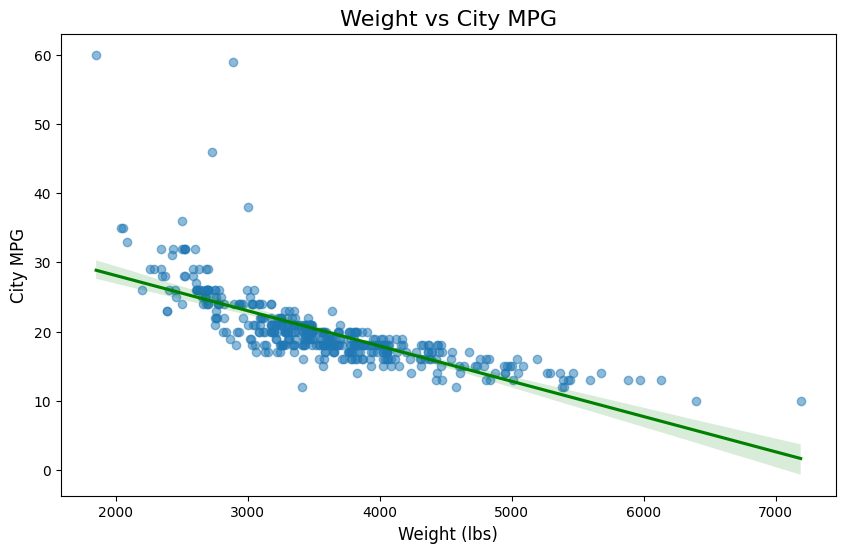

In [ ]:
# Convert to Pandas for regression plot
pandas_weight_mpg = car_sales_df.select("Weight", "MPG_City").toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(data=pandas_weight_mpg, x="Weight", y="MPG_City", scatter_kws={"alpha": 0.5}, line_kws={"color": "green"})
plt.title("Weight vs City MPG", fontsize=16)
plt.xlabel("Weight (lbs)", fontsize=12)
plt.ylabel("City MPG", fontsize=12)
plt.show()


<ipython-input-10-a7e805dc604f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pandas_price_gap_by_type, x="Type", y="Avg_Price_Gap", palette="Blues_d")


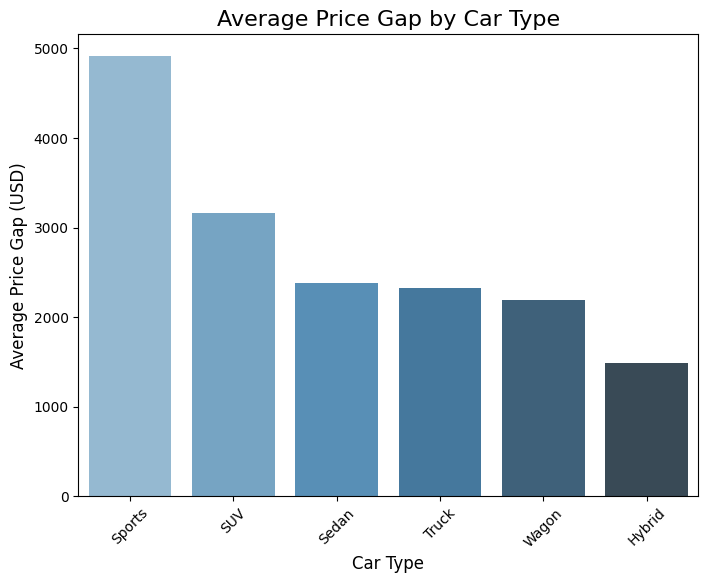

In [ ]:
# Add Price_Gap column
car_sales_df = car_sales_df.withColumn("Price_Gap", col("MSRP") - col("Invoice"))

# Group by Type
price_gap_by_type = car_sales_df.groupBy("Type").agg(mean("Price_Gap").alias("Avg_Price_Gap")).orderBy("Avg_Price_Gap", ascending=False)
pandas_price_gap_by_type = price_gap_by_type.toPandas()

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=pandas_price_gap_by_type, x="Type", y="Avg_Price_Gap", palette="Blues_d")
plt.title("Average Price Gap by Car Type", fontsize=16)
plt.xlabel("Car Type", fontsize=12)
plt.ylabel("Average Price Gap (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.show()
